# Exploratory Data Analysis (EDA) ([#3](https://github.com/molinari135/embryo-project/issues/3))

In this notebook, we perform the following operations:

1. Rename all columns in english
2. Remove all rows that have `NaN` in folder field
3. Remove columns that will not be used
4. Change the label using 0s and 1s instead of strings
5. Convert the original file in `.tsv`

In order to perform all these operations it is **required** do to run the previous notebooks by number convention.

In [38]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from loguru import logger
from embryo_project.config import PROCESSED_DATA_DIR, FIGURES_DIR, ANNOTATIONS_FILE

In [39]:
file_path = Path(ANNOTATIONS_FILE)
df = pd.read_csv(file_path, sep="\t")
df.head()

,folder,label,image
0,D2020.10.07_S00020_I4203_P_WELL01,0,D2020.10.07_S00020_I4203_P_WELL01_RUN361
1,D2020.10.07_S00020_I4203_P_WELL02,0,D2020.10.07_S00020_I4203_P_WELL02_RUN104
2,D2020.10.07_S00020_I4203_P_WELL03,0,D2020.10.07_S00020_I4203_P_WELL03_RUN296
3,D2020.10.07_S00020_I4203_P_WELL04,0,D2020.10.07_S00020_I4203_P_WELL04_RUN198
4,D2020.10.07_S00020_I4203_P_WELL05,0,D2020.10.07_S00020_I4203_P_WELL05_RUN156


label
0    94.064386
1     5.935614
Name: proportion, dtype: float64


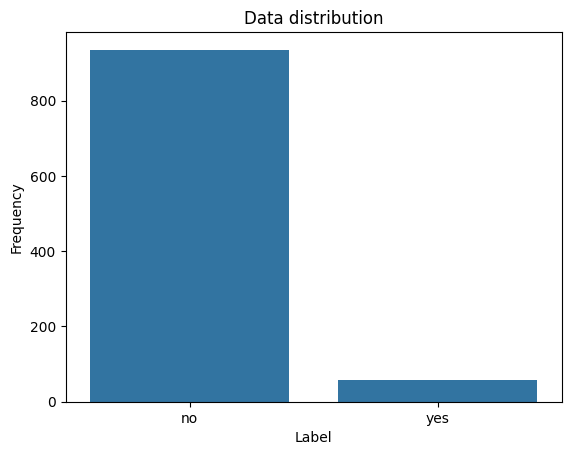

In [47]:
print(df['label'].value_counts(normalize=True) * 100)

sns.countplot(data=df, x='label')
plt.title('Data distribution')
plt.xticks(ticks=[0, 1], labels=['no', 'yes'])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.savefig(FIGURES_DIR / "3a-label-distribution.png")
plt.show()

In [41]:
def extract_run_number(filename):
    match = re.search(r'_RUN(\d+)', filename)
    return int(match.group(1)) if match else -1

summary = []

for folder_name in df['folder'].unique():
    folder_df = df[df['folder'] == folder_name]
    labeled_images = folder_df['image'].dropna().tolist()
    labeled_images = sorted(labeled_images, key=extract_run_number)

    folder_path = PROCESSED_DATA_DIR / folder_name
    if not folder_path.exists():
        logger.warning(f"Folder not found: {folder_path}")
        continue

    # They should be already sorted
    image_files = sorted(
        [f for f in folder_path.glob("*.JPG")],
        key=lambda x: extract_run_number(x.name)
    )

    if not image_files:
        logger.warning(f"No images in {folder_path}")
        continue

    first_labeled_image = labeled_images[0] if labeled_images else None
    first_run_number = extract_run_number(first_labeled_image) if first_labeled_image else float('inf')

    labeled_count = 0
    for img in image_files:
        if extract_run_number(img.name) >= first_run_number:
            labeled_count += 1

    total_images = len(image_files)
    neutral_count = total_images - labeled_count

    summary.append({
        'folder': folder_name,
        'total_images': total_images,
        'labeled_images': labeled_count,
        'not_labeled_images': neutral_count
    })

summary_df = pd.DataFrame(summary)
summary_df

2025-08-04 16:43:52.878 | WARNING  | __main__:<module>:14 - Folder not found: C:\Users\Molinari\Desktop\embryo-project\data\processed\D2020.10.07_S00023_I4203_P_WELL16
2025-08-04 16:43:52.926 | WARNING  | __main__:<module>:14 - Folder not found: C:\Users\Molinari\Desktop\embryo-project\data\processed\D2020.10.28_S00032_I4203_P_WELL01
2025-08-04 16:43:52.926 | WARNING  | __main__:<module>:14 - Folder not found: C:\Users\Molinari\Desktop\embryo-project\data\processed\D2020.10.28_S00032_I4203_P_WELL02
2025-08-04 16:43:52.926 | WARNING  | __main__:<module>:14 - Folder not found: C:\Users\Molinari\Desktop\embryo-project\data\processed\D2020.10.28_S00032_I4203_P_WELL03
2025-08-04 16:43:52.926 | WARNING  | __main__:<module>:14 - Folder not found: C:\Users\Molinari\Desktop\embryo-project\data\processed\D2020.10.28_S00032_I4203_P_WELL04
2025-08-04 16:43:52.927 | WARNING  | __main__:<module>:14 - Folder not found: C:\Users\Molinari\Desktop\embryo-project\data\processed\D2020.10.28_S00032_I4203_P

,folder,total_images,labeled_images,not_labeled_images
0,D2020.10.07_S00020_I4203_P_WELL01,20,11,9
1,D2020.10.07_S00020_I4203_P_WELL02,20,17,3
2,D2020.10.07_S00020_I4203_P_WELL03,20,12,8
3,D2020.10.07_S00020_I4203_P_WELL04,20,14,6
4,D2020.10.07_S00020_I4203_P_WELL05,20,15,5
...,...,...,...,...
976,D2023.09.06_S00200_I4203_P_WELL08,21,6,15
977,D2023.09.06_S00200_I4203_P_WELL09,21,18,3
978,D2023.09.06_S00200_I4203_P_WELL10,21,15,6
979,D2023.09.06_S00200_I4203_P_WELL11,21,19,2


- `D2020.10.07_S00023_I4203_P_WELL16` was empty in the original dataset
- `D2020.10.28_S00032` does not exists
- `D2021.06.16_S00057` does not exists
- `D2022.09.07_S00152_I4203_P_WELL11` was empty in the original dataset

In [ ]:
label_1_count = (df['label'] == 1).sum()
label_0_count = (df['label'] == 0).sum()
neutral_count = df['label'].isna().sum()

print(f"Immagini con label 1 (blastocisti sì): {label_1_count}")
print(f"Immagini con label 0 (blastocisti no): {label_0_count}")
print(f"Immagini senza etichetta (neutre): {neutral_count}")

Immagini con label 1 (blastocisti sì): 59
Immagini con label 0 (blastocisti no): 935
Immagini senza etichetta (neutre): 0


In [59]:
def extract_run_number(filename):
    match = re.search(r'_RUN(\d+)', filename)
    return int(match.group(1)) if match else -1

label_1_count = 0
label_0_count = 0
neutral_count = 0

for folder_name in df['folder'].unique():
    folder_path = PROCESSED_DATA_DIR / folder_name
    if not folder_path.exists():
        continue

    image_files = sorted(folder_path.glob("*.JPG"), key=lambda x: extract_run_number(x.name))
    if not image_files:
        continue

    folder_df = df[df['folder'] == folder_name]

    # Take all images with label 1, if any
    labeled_1_images = folder_df[folder_df['label'] == 1]['image'].dropna().tolist()
    # Take all images with albel 0, if any
    labeled_0_images = folder_df[folder_df['label'] == 0]['image'].dropna().tolist()

    if labeled_1_images:
        min_run = min(extract_run_number(img) for img in labeled_1_images)
        label_type = 1
    elif labeled_0_images:
        min_run = min(extract_run_number(img) for img in labeled_0_images)
        label_type = 0
    else:
        # No label, all neutral
        neutral_count += len(image_files)
        continue

    for img in image_files:
        run_num = extract_run_number(img.name)
        if run_num >= min_run:
            if label_type == 1:
                label_1_count += 1
            else:
                label_0_count += 1
        else:
            neutral_count += 1

print(f"Images with label 1: {label_1_count}")
print(f"Images with label 0: {label_0_count}")
print(f"Images with no label: {neutral_count}")

Images with label 1: 312
Images with label 0: 12597
Images with no label: 6972
